## Bayesian Importance Weighted Probabilistic Matrix Factorization

This python module implements a class 'MatrixFactorization' which carries out Bayesian inference for Probabilistic Matrix Factorization (PMF) with importance weights / heteroscedastic measurement errors. The generative model assumes that the matrix entries $y_{ij}$'s have (conditionally) independent distributions given a parameter $\boldsymbol{\theta} = (\mathbf{r}, \mathbf{c}, \mathbf{u}, \mathbf{v})$ as follows:
$$ y_{ij} \, | \, \boldsymbol{\theta} \sim \mathcal{N}(\mu_{ij}(\boldsymbol{\theta}), w_{ij}^{-1}), \quad \mu_{ij}(\boldsymbol{\theta}) = r_i + c_j + \langle \mathbf{u}_i, \mathbf{v}_j \rangle $$
where $\mathcal{N}(\mu, \sigma^2)$ denotes the Gaussian distribution with mean $\mu$ and variance $\sigma^2$. The inverse variance $w_{ij} = \text{Var}(y_{ij} | \boldsymbol{\theta})^{-1}$ is sometimes referred to as *importance weight* on the observation $y_{ij}$. The row and column biases $\mathbf{r}, \mathbf{c}$ and latent factors $\mathbf{u}_i, \mathbf{v}_j$ are given independent Gaussian priors:
$$\mathbf{r} \sim \mathcal{N}(0, \sigma_r^2 \mathbf{I}), \quad
\mathbf{c} \sim \mathcal{N}(0, \sigma_c^2 \mathbf{I}), \quad
\mathbf{u}_i \sim \mathcal{N}(0, \sigma_f^2 \mathbf{I}), \quad
\mathbf{v}_j \sim \mathcal{N}(0, \sigma_f^2 \mathbf{I})$$
<!--- (Note that no additional flexibility is gained by choosing different prior variances for $\mathbf{u}_i$'s and $\mathbf{v}_j$'s since they are always multiplied together.) -->
Maximixing the posterior probability of this generative model corresponds to minimizing a loss
$$\ell(\mathbf{y} ; \boldsymbol{\theta})
    = \sum_{i,j} w_{ij} \Vert y_{ij} - \mu_{ij}(\boldsymbol{\theta}) \Vert^2 
    + \frac{1}{\sigma_r^2} \Vert \mathbf{r} \Vert
    + \frac{1}{\sigma_c^2} \Vert \mathbf{c} \Vert 
    + \frac{1}{\sigma_f^2} \sum_i \Vert \mathbf{u}_i \Vert
    + \frac{1}{\sigma_f^2} \sum_j \Vert \mathbf{v}_j \Vert$$
Instead of optimizing the regularized loss function, however, the module implements a Gibbs sampler to reap the benefits of Bayesian approach, such as quantification of posterior uncertainty as well as a relative robustness to the choice of regularization parameters and the number of factors.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.sparse as sparse

%matplotlib inline

## Ilustration of the generative model with weighted / heteroscedastic noises.

#### Generate a synthetic data with column and row biases only.

In [2]:
nrow = 10
ncol = 20
num_factor = 2
signal_level = 1
noise_level = .1
seed = 1
np.random.seed(seed)

w0 = (noise_level * np.random.standard_cauchy(size=(nrow, ncol))) ** -2
r0 = signal_level * np.random.randn(nrow, 1)
c0 = signal_level * np.random.randn(ncol, 1)
e0 = np.random.randn(nrow, ncol) / np.sqrt(w0)
y0 = np.outer(r0, np.ones((ncol, 1))) + np.outer(np.ones((nrow, 1)), c0)
y = y0 + e0

#### Make a heat plot to indicate how (un) imporatnt / reliable each observed entry $y_{ij}$ is. Larger noise indicates lesser importance / reliability.

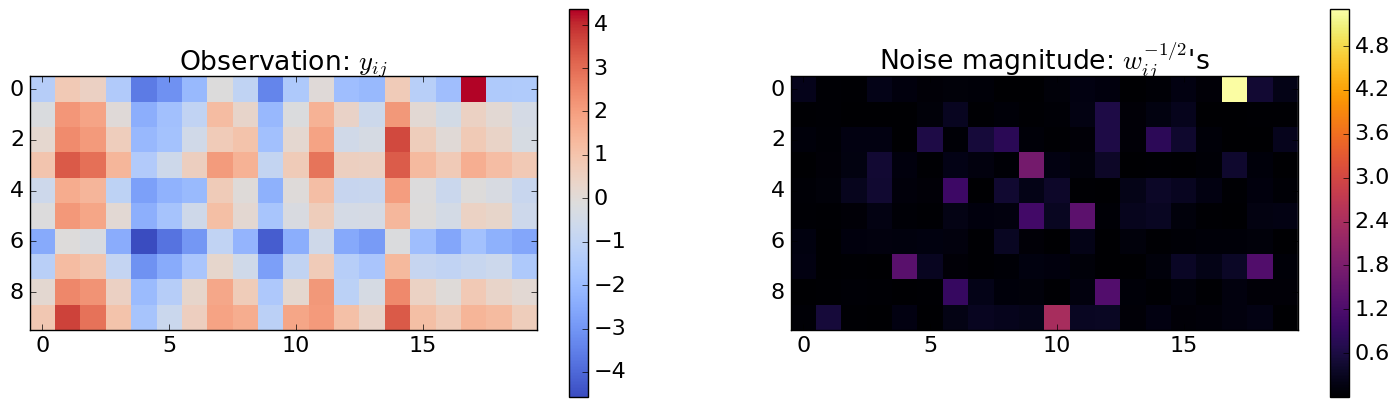

In [3]:
plt.figure(figsize=(18, 5))
plt.rcParams['font.size'] = 16

plt.subplot(1,2,1)
plt.imshow(y, interpolation='none', cmap='coolwarm')
plt.title("Observation: $y_{ij}$")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(1 / np.sqrt(w0), interpolation='none', cmap='inferno')
plt.title(r"Noise magnitude: $w_{ij}^{-1/2}$'s")
plt.colorbar()

plt.show()

## Illustration of how to use the module

#### Generate a synthetic data.

In [4]:
nrow = 500
ncol = 1000

num_factor = 2
signal_level = 1
noise_level = .25
w0 = (noise_level * np.random.exponential(size=(nrow, ncol))) ** -2

r0 = signal_level * np.random.randn(nrow, 1)
c0 = signal_level * np.random.randn(ncol, 1)
u0 = math.sqrt(signal_level) * np.random.randn(nrow, num_factor)
v0 = math.sqrt(signal_level) * np.random.randn(ncol, num_factor)
e0 = np.random.randn(nrow, ncol) / np.sqrt(w0)
y0 = np.outer(r0, np.ones((ncol, 1))) + np.outer(np.ones((nrow, 1)), c0) + np.dot(u0, v0.T)
y = y0 + e0

#### Make a sparse training / observed matrix. 

In [5]:
y0_coo = sparse.coo_matrix(y0)
y_coo = sparse.coo_matrix(y)

sampling_rate = .05
is_observed = np.random.binomial(1, sampling_rate, size=nrow * ncol).astype(np.bool)
is_unobserved = np.logical_not(is_observed)
y_train_coo = sparse.coo_matrix((y_coo.data[is_observed], (y_coo.row[is_observed], y_coo.col[is_observed])), shape=y.shape)
weight_train = w0.flatten()[is_observed]
y_test_coo = sparse.coo_matrix((y_coo.data[is_unobserved], (y_coo.row[is_unobserved], y_coo.col[is_unobserved])), shape=y.shape)

#### Train the model / get posterior samples using the MatrixFactorization class.

The convergence of MCMC can be slow for some data sets. Alternating least squares works very similarly to MCMC, but gradient descent with momentum could converge faster (not investigated).

In [6]:
%%time
from matrix_factorization import MatrixFactorization as MF

# Prior parameters for the model
bias_scale = signal_level
factor_scale = math.sqrt(signal_level)
mf = MF(y_train_coo, num_factor, bias_scale, factor_scale, weight_train)

# Gibbs update of the latent factors can be parallelized, though the overhead
# of multi-processing overwhelms for not very large matrices.
n_burnin = 25 * 10 ** 3
n_mcmc = 1000
y_post_mean, sample_dict = mf.gibbs(n_burnin, n_mcmc, n_update=10, num_process=1)

2600 iterations have been completed.
The log posterior density has increased by 1.53e+07 from the initial value so far.
5200 iterations have been completed.
The log posterior density has increased by 1.53e+07 from the initial value so far.
7800 iterations have been completed.
The log posterior density has increased by 1.54e+07 from the initial value so far.
10400 iterations have been completed.
The log posterior density has increased by 1.54e+07 from the initial value so far.
13000 iterations have been completed.
The log posterior density has increased by 1.54e+07 from the initial value so far.
15600 iterations have been completed.
The log posterior density has increased by 1.56e+07 from the initial value so far.
18200 iterations have been completed.
The log posterior density has increased by 1.56e+07 from the initial value so far.
20800 iterations have been completed.
The log posterior density has increased by 1.56e+07 from the initial value so far.
23400 iterations have been complete

#### Check the convergence of MCMC 

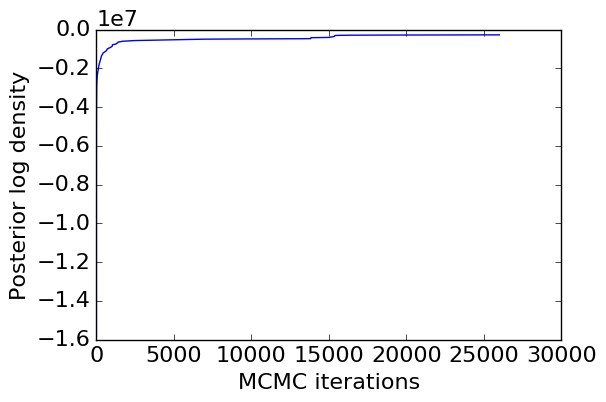

In [7]:
plt.plot(sample_dict['logp'])
plt.xlabel('MCMC iterations')
plt.ylabel('Posterior log density')
plt.show()

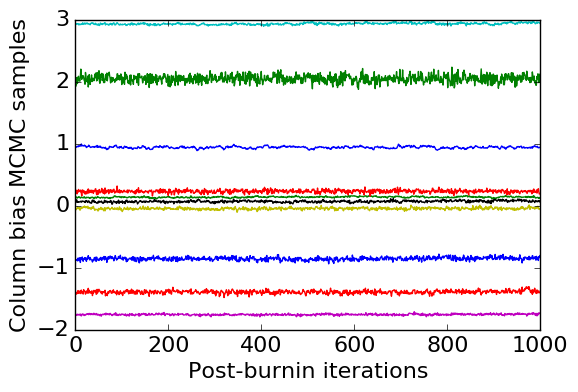

In [8]:
plt.plot(sample_dict['c'][:10,:].T)
plt.xlabel('Post-burnin iterations')
plt.ylabel('Column bias MCMC samples')
plt.show()

### Check if the in-sample model output agree with the training data for sanity check.

In [9]:
def add_refline():
    # Adds a 45 degree angle line passing the origin.
    axes = plt.gca()
    min_val = np.min(np.hstack([axes.get_ylim()[0], axes.get_xlim()[0]]))
    max_val = np.max(np.hstack([axes.get_ylim()[1], axes.get_xlim()[1]]))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

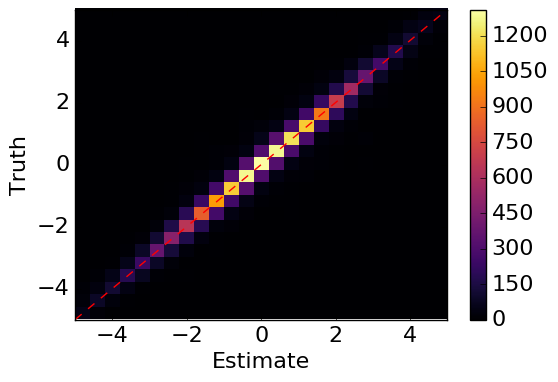

In [10]:
y_post_samples = mf.compute_model_mean_sample(y_train_coo.row, y_train_coo.col, sample_dict, 
                                              thin=1, n_discard=0)
y_post_mean = np.mean(y_post_samples, 1)

plt.hist2d(y_post_mean, y0_coo.data[is_observed], bins=25, range=np.array([[-5, 5], [-5, 5]]), cmap='inferno')
add_refline()
plt.xlabel('Estimate')
plt.ylabel('Truth')
plt.colorbar()
plt.show()

### Check if the column and row biases are (approximately) recovered by MCMC.

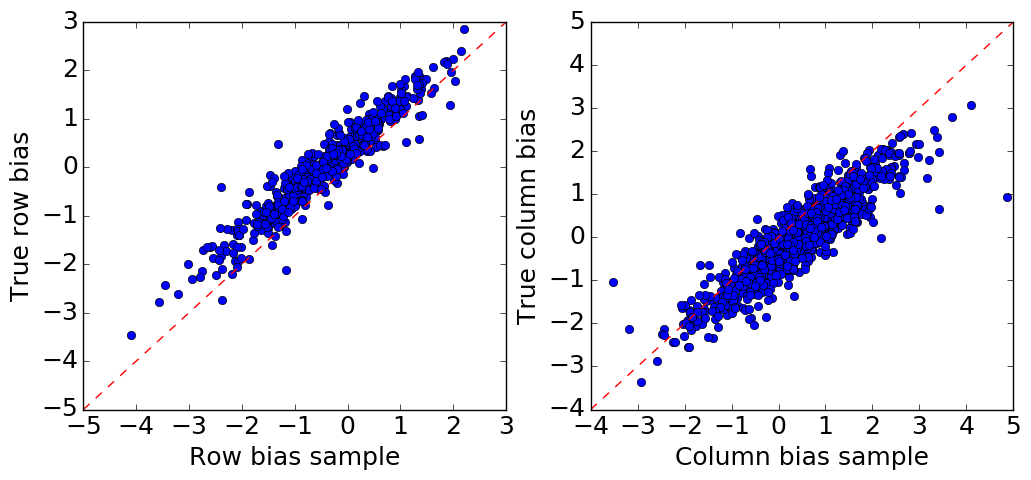

In [11]:
plt.figure(figsize=(12, 5), dpi=80)
plt.rcParams['font.size'] = 18

plt.subplot(1,2,1)
plt.plot(np.median(sample_dict['r'], 1), r0, 'o')
add_refline()
plt.xlabel('Row bias sample')
plt.ylabel('True row bias')

plt.subplot(1,2,2)
plt.plot(np.median(sample_dict['c'],1), c0, 'o')
add_refline()
plt.xlabel('Column bias sample')
plt.ylabel('True column bias')

plt.show()

### Check out of sample prediction ability of the model.

In [12]:
y_pred_samples = mf.compute_model_mean_sample(y_test_coo.row, y_test_coo.col, sample_dict, 
                                              thin=10, n_discard=0)
y_pred_mean = np.mean(y_pred_samples, 1)
mse = np.mean((y_pred_mean - y_test_coo.data) ** 2)
R_sq = 1 - mse / np.var(y_test_coo.data)
print("The matrix factorization model explains {:.2f}% of variability in the test data.".format(R_sq * 100))

The matrix factorization model explains 81.17% of variability in the test data.
